In [47]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from typing import Annotated
import json
import httpx
from tavily import TavilyClient
import asyncio

In [48]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

api_key = os.getenv("QWEN_API_KEY")
base_url = os.getenv("QWEN_API_BASE_URL")
tavily_key = os.getenv("TAVILY_API_KEY")

llm = ChatOpenAI(model="qwen-plus-latest",api_key=api_key,base_url=base_url,temperature=0.01)
tavily_client = TavilyClient(api_key=tavily_key)

In [49]:
class OverallState(TypedDict):
    url: str
    result: str
    status: str

In [65]:
async def tavily_node(state:OverallState):
    response = await asyncio.to_thread(tavily_client.extract, state['url'])
    # response = tavily_client.extract(state['url'])
    return {"result":response['results'][0]['raw_content']}

async def jina_node(state:OverallState):
    async with httpx.AsyncClient() as client:
        response = await client.get(f"https://r.jina.ai/{state['url']}",timeout=30)
    if response.status_code!= 200:
        return {"status":"error"}
    else:
        return {"result":response.text}
    # response = httpx.get(f"https://r.jina.ai/{state['url']}")
    # return {"result":response.text}

In [56]:
response = httpx.get('https://r.jina.ai/https://www.chinaisa.org.cn/gxportal/xfgl/portal/content.html?articleId=d7745de7d63aa5bc4cf180587e940458550ac2e4d84cc844fd3aba2349f0f29b&columnId=c42511ce3f868a515b49668dd250290c80d4dc8930c7e455d0e6e14b8033eae2')

In [57]:
response.text

"Title: 专家解读：加强碳足迹核算标准供给，促进产业绿色低碳转型升级－中国钢铁工业协会\n\nURL Source: https://www.chinaisa.org.cn/gxportal/xfgl/portal/content.html?articleId=d7745de7d63aa5bc4cf180587e940458550ac2e4d84cc844fd3aba2349f0f29b&columnId=c42511ce3f868a515b49668dd250290c80d4dc8930c7e455d0e6e14b8033eae2\n\nPublished Time: Tue, 14 Nov 2023 06:24:44 GMT\n\nMarkdown Content:\n专家解读：加强碳足迹核算标准供给，促进产业绿色低碳转型升级－中国钢铁工业协会\n\n===============\n\n[![Image 1: logo](https://www.chinaisa.org.cn/gxportal/xfgl/portal/img/logo.jpg)](https://www.chinaisa.org.cn/gxportal/xfgl/portal/index.html)\n\n[](javascript:serach();)\n\n[![Image 2](https://www.chinaisa.org.cn/gxportal/xfgl/portal/img/icon-user-ind.jpg) 会员登录](https://www.chinaisa.org.cn/gxportal/login.html)[![Image 3](https://www.chinaisa.org.cn/gxportal/xfgl/portal/img/icon-email-ind.jpg) 秘书长信箱](mailto:mszxx@chinaisa.org.cn)[En](http://english.chinaisa.org.cn/do/index.jsp)[钢协邮箱登录](http://mail.chinaisa.org.cn/login_chinaisa.jsp)\n\n*   [首页](https://www.chinaisa.org.cn/gxportal/xfgl/po

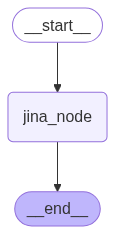

In [66]:
graph_builder = StateGraph(OverallState)

graph_builder.add_node("jina_node",jina_node)
graph_builder.add_edge(START,"jina_node")
graph_builder.add_edge("jina_node",END)

graph = graph_builder.compile()
graph

In [71]:
result = await graph.ainvoke({"url": "https://finance.eastmoney.com/a/202507033447776215.html"})

In [ ]:
print(result['result'])